# Wine Data

## Previous information

### Dataset

These data are the results of a chemical analysis of wines grown in the **same region in Italy** but derived **from three different cultivars**. The analysis determined the quantities of 13 constituents found in each of the **three types of wines**.


### Objetive

Explore the provided wine dataset to **uncover interesting patterns, profiles, or correlations** among the different chemical constituents of the wines. The challenge is open-ended, encouraging creative and exploratory analysis.

### Dicctionary of features

**Alcohol:** El contenido de alcohol en el vino, expresado como porcentaje de alcohol por volumen. Es un factor clave que afecta el sabor y la estructura del vino.

**Malic acid:** El ácido málico es un ácido orgánico presente en las uvas y, por lo tanto, en el mosto antes de la fermentación. Puede afectar la acidez y el sabor del vino.

**Ash:** La cantidad total de minerales en el vino después de su incineración. Este valor puede proporcionar información sobre la mineralidad del vino.

**Alcalinity of ash:** La alcalinidad de las cenizas es la medida de la capacidad de una sustancia para neutralizar la acidez. En el contexto del vino, esto puede influir en la percepción del equilibrio ácido-base.

**Magnesium:** La cantidad de magnesio presente en el vino. El magnesio puede afectar la fermentación y puede tener implicaciones para la textura y el sabor del vino.

**Total phenols:** La concentración total de compuestos fenólicos en el vino. Los fenoles contribuyen a la estructura, el color y el sabor del vino.

**Flavanoids:** Los flavonoides son un tipo de fenol y contribuyen al color y la complejidad del vino. También pueden tener beneficios para la salud.

**Nonflavanoid phenols:** Otro grupo de compuestos fenólicos que no son flavonoides. También pueden contribuir a la estructura y el sabor del vino.

**Proanthocyanins:** Compuestos fenólicos que pertenecen a la familia de los taninos. Contribuyen a la astringencia y la sensación en boca del vino.

**Color intensity:** La intensidad del color del vino, que puede estar relacionada con la concentración de pigmentos y fenoles.

**Hue:** El tono del color del vino, medido en grados. Puede proporcionar información sobre la variación en el color.

**OD280/OD315 of diluted wines:** La relación entre las absorbancias ópticas a longitudes de onda específicas. Puede ser indicativo de la concentración de compuestos fenólicos y otros factores en el vino.

**Proline:** Un aminoácido que se encuentra en las uvas y puede influir en la estabilidad y el sabor del vino. La cantidad de proline en el vino puede estar relacionada con la calidad de la uva.

## Preparation

### Import libraries

In [2]:
!pip install kneed -q

In [3]:
import os
import numpy as np
import pandas as pd
from kneed import KneeLocator

from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler)
from sklearn.decomposition import PCA
from sklearn.cluster import (AgglomerativeClustering,
                             AffinityPropagation,
                             SpectralClustering,
                             DBSCAN,
                             KMeans)
from sklearn.metrics import (silhouette_score,
                             silhouette_samples,
                             calinski_harabasz_score)

import matplotlib.pyplot as plt
import seaborn as sns

### Functions

In [4]:
def create_folder(filename,verbose=False):
  try:
    os.mkdir(filename)
  except:
    if verbose:
      print("Folder already created")

In [5]:
def download_dataset(link,name_dataset,folder):
  create_folder(folder)
  os.system(f'wget {link} -q -O "{folder}/{name_dataset}"')

In [6]:
def plot_model(X_pca,labels,model_name,cmap='viridis'):
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap=cmap)
  plt.title(f'Clusters obtained with {model_name}')
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.show()

In [7]:
def plot_elbow_comparation(rng,inertia_values,model_name):
  kn = KneeLocator(rng, inertia_values, curve='convex', direction='decreasing')
  xelbow = kn.knee
  xpos = rng.index(kn.knee)
  yelbow = inertia_values[xpos]

  plt.plot(rng, inertia_values, marker='o')
  plt.scatter(xelbow, yelbow, s=200, facecolors='none', edgecolors='r')
  plt.annotate('elbow', xy=(xelbow, yelbow), xytext=(xelbow*1.02, yelbow*1.02))
  plt.title(f'Elbow Method - {model_name}')
  plt.xlabel('Number of Clusters (K)')
  plt.ylabel('Sum of intra-cluster distances')
  plt.show()

In [8]:
def plot_silhouette_comparation(rng,silhouette_avg_values,model_name):
  ymax = max(silhouette_avg_values)
  xpos = np.argmax(silhouette_avg_values)
  xmax = rng[xpos]

  plt.plot(rng, silhouette_avg_values, marker='o')
  plt.scatter(xmax, ymax, s=200, facecolors='none', edgecolors='r')
  plt.annotate('max', xy=(xmax, ymax), xytext=(xmax*1.06, ymax*1.00))
  plt.title(f'Silhouette Method - {model_name}')
  plt.xlabel('Number of Clusters (K)')
  plt.ylabel('Average of silhouette')
  plt.show()

## Data Exploration

### Load dataset

In [9]:
download_dataset('https://storage.googleapis.com/the_public_bucket/wine-clustering.csv','wine-clustering.csv','datasets')

In [10]:
df_wines = pd.read_csv('datasets/wine-clustering.csv')
df_wines.head()

Alcohol  Malic_Acid   Ash  Ash_Alcanity  Magnesium  Total_Phenols  \
0    14.23        1.71  2.43          15.6        127           2.80   
1    13.20        1.78  2.14          11.2        100           2.65   
2    13.16        2.36  2.67          18.6        101           2.80   
3    14.37        1.95  2.50          16.8        113           3.85   
4    13.24        2.59  2.87          21.0        118           2.80   

   Flavanoids  Nonflavanoid_Phenols  Proanthocyanins  Color_Intensity   Hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   OD280  Proline  
0   3.92     1065  
1   3.40     1050  
2   3.17     1185  
3   3.45     1480  
4   2.93      735

### Null Verification

In [11]:
print(df_wines.isnull().sum())

Alcohol                 0
Malic_Acid              0
Ash                     0
Ash_Alcanity            0
Magnesium               0
Total_Phenols           0
Flavanoids              0
Nonflavanoid_Phenols    0
Proanthocyanins         0
Color_Intensity         0
Hue                     0
OD280                   0
Proline                 0
dtype: int64


No hay datos nulos o vacíos, por lo que se puede continuar con el proceso.

### Statistical summary

In [12]:
df_wines.describe()

Alcohol  Malic_Acid         Ash  Ash_Alcanity   Magnesium  \
count  178.000000  178.000000  178.000000    178.000000  178.000000   
mean    13.000618    2.336348    2.366517     19.494944   99.741573   
std      0.811827    1.117146    0.274344      3.339564   14.282484   
min     11.030000    0.740000    1.360000     10.600000   70.000000   
25%     12.362500    1.602500    2.210000     17.200000   88.000000   
50%     13.050000    1.865000    2.360000     19.500000   98.000000   
75%     13.677500    3.082500    2.557500     21.500000  107.000000   
max     14.830000    5.800000    3.230000     30.000000  162.000000   

       Total_Phenols  Flavanoids  Nonflavanoid_Phenols  Proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min         0.980000    0.340000              0.130000         0.410000   
25%         1.742500    1.205000              0.270000         1.250000   
50%         2.355000    2.135000              0.340000         1.555000   
75%         2.800000    2.875000              0.437500         1.950000   
max         3.880000    5.080000              0.660000         3.580000   

       Color_Intensity         Hue       OD280      Proline  
count       178.000000  178.000000  178.000000   178.000000  
mean          5.058090    0.957449    2.611685   746.893258  
std           2.318286    0.228572    0.709990   314.907474  
min           1.280000    0.480000    1.270000   278.000000  
25%           3.220000    0.782500    1.937500   500.500000  
50%           4.690000    0.965000    2.780000   673.500000  
75%           6.200000    1.120000    3.170000   985.000000  
max          13.000000    1.710000    4.000000  1680.000000

En el cuadro de resumen, se puede ver que los rangos de valores de los características son variadas y en distintas escalas. Como se usará  algoritmos de clusterización, será mejor **reducir las escalas**. Podría ser Standard Scaler o MinMax Scaler, por lo que sería necesario estudiar las distribuciones del dataset.

### Distribution of features

In [13]:
df = df_wines.copy()
X = df.values

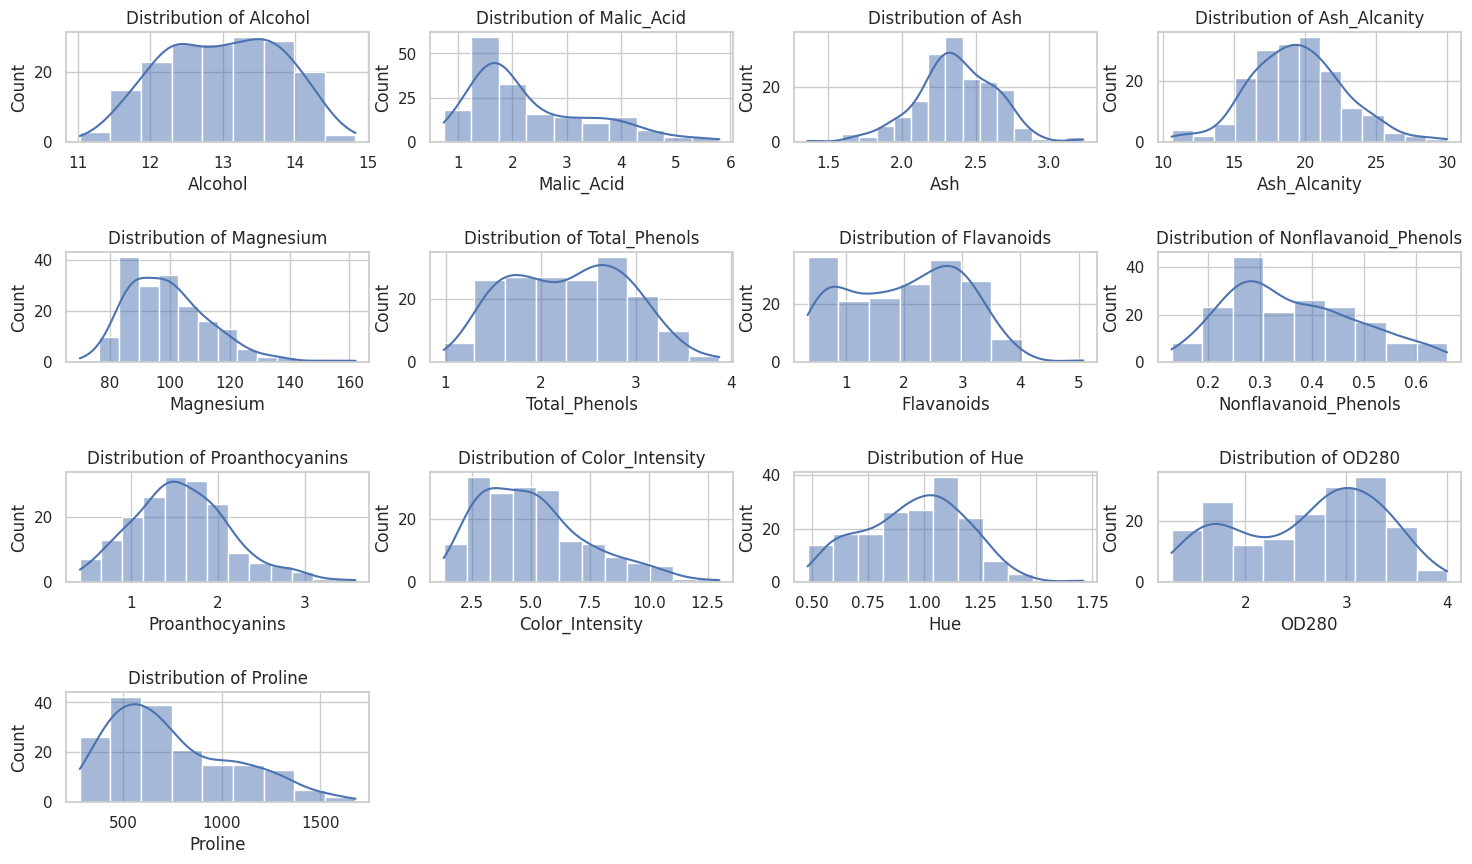

In [14]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=1)

for i, column in enumerate(df.columns):
    plt.subplot(4, 4, i + 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')

plt.show()

En esta parte, se visualiza las distribuciones de los valores de cada característica. Se puede observar que en casi todos, tienen un valor central donde se concentra la mayoría de valores. Por lo tanto, al tener este tipo de distribución, sería recomendable usar **Standard Scaler**, en vez de MinMax Scaler.

### Correlation Matrix

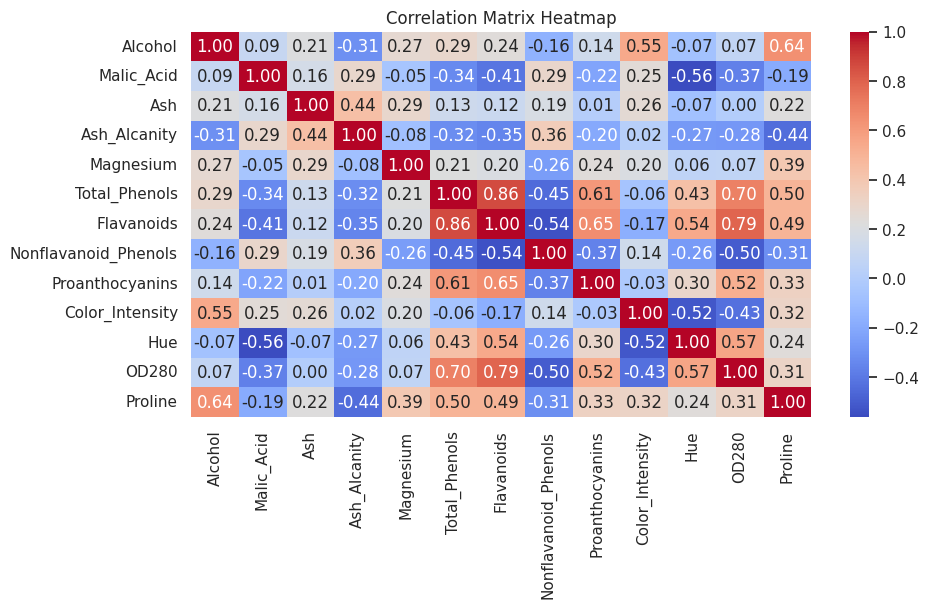

In [15]:
correlation_matrix = df_wines.corr()

plt.figure(figsize = (10,5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

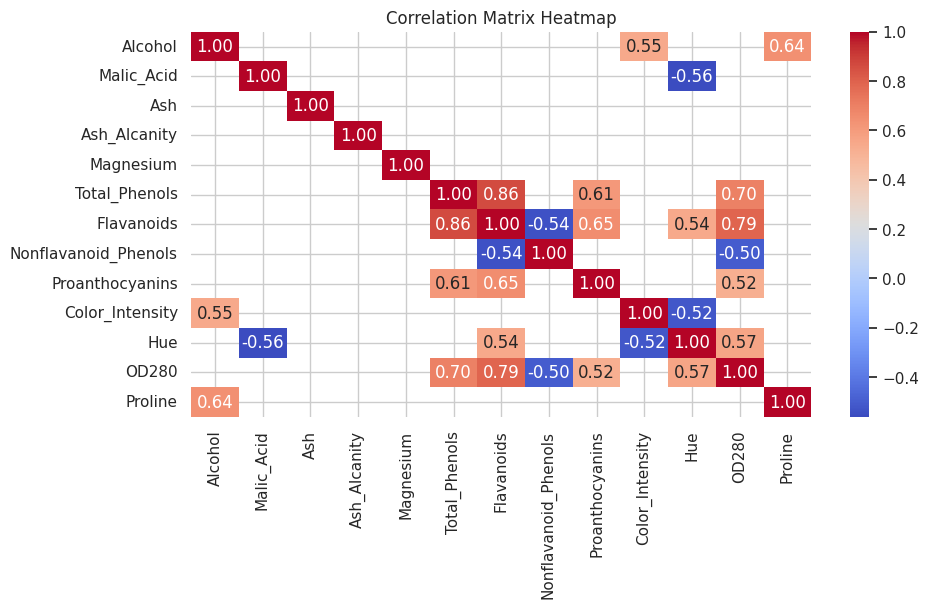

In [16]:
correlation_matrix = df_wines.corr()

plt.figure(figsize = (10,5))
sns.heatmap(correlation_matrix[(correlation_matrix > 0.5) | (correlation_matrix < -0.5)], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

En la matriz de correlación del dataset, se encontraron lo siguiente:
* Alcohol está correlacionado con Intensidad de Color y Prolina
* Ácido Málico está inversamente correlacionado con Tono
* Fenoles Totales está fuertemente correlacionado con Flavanoides y OD280, y moderamente correlacionada con Proantocianidina.
* Flavanoides está inversamente correlacionado con Fenoles No Flavanoides, esta correlacionado con Proantocianidina y Tono, y fuertemente correlacionado con OD280.
* Fenoles No Flavanoides está inversamente correlacionado con OD280
* Proantocianidina esta correlacionado con OD280
* Intensidad de Color está inversamente correlacionado con Tono.
* Tono está correlacionado con OD280

### Standard Scale

In [17]:
scaler = StandardScaler()
X_standard = scaler.fit_transform(X)

### Dimensional Reduction with PCA for plotting

In [18]:
pca = PCA(n_components=2)
X_pca_standard = pca.fit_transform(X_standard)

## Clustering Analysis

Hyperparameters

In [19]:
num_clusters = 3
random_state = 42

### KMeans

#### Fit and Prediction

In [20]:
kmeans = KMeans(n_clusters=num_clusters,  n_init='auto', random_state=random_state)

df['Cluster_KMeans'] = kmeans.fit_predict(X_standard)
print("Number of elements in Clusters")
print(df['Cluster_KMeans'].value_counts())

Number of elements in Clusters
0    64
1    63
2    51
Name: Cluster_KMeans, dtype: int64


#### Plot model prediction

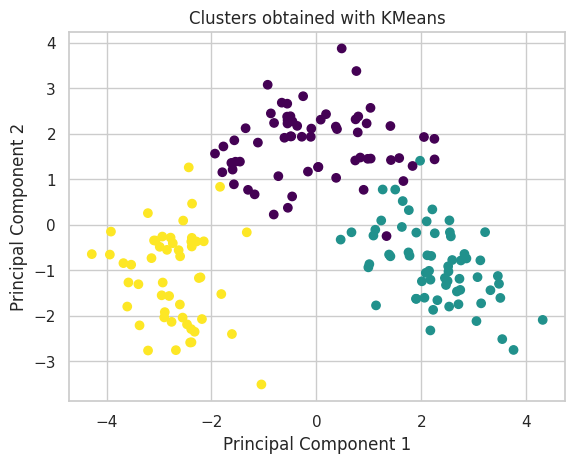

In [21]:
plot_model(X_pca_standard, df['Cluster_KMeans'], 'KMeans')

#### Elbow Method

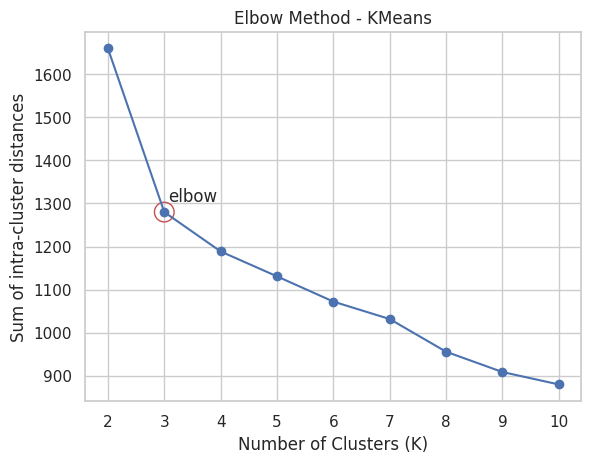

In [22]:
inertia_values = []
rng = range(2, 11)

for k in rng:
    model_temp = KMeans(n_clusters=k, n_init='auto', random_state=random_state)
    model_temp.fit(X_standard)
    inertia_values.append(model_temp.inertia_)

plot_elbow_comparation(rng,inertia_values,'KMeans')

#### Silhouette Method

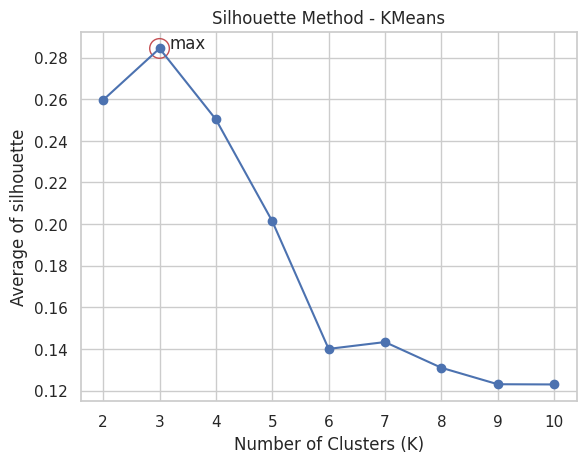

In [23]:
silhouette_avg_values = []

for k in range(2, 11):  # Puedes ajustar el rango según tus necesidades
    model_temp = KMeans(n_clusters=k, n_init='auto', random_state=random_state)
    clusters = model_temp.fit_predict(X_standard)
    silhouette_avg = silhouette_score(X_standard, clusters)
    silhouette_avg_values.append(silhouette_avg)

plot_silhouette_comparation(rng,silhouette_avg_values,'KMeans')

Se inició con 3 clusters debido a la premisa de que existen 3 viñedos. Aplicando el Método de Codo y el Método de Silueta, se puedo comprobar que el mejor número de cluster para este dataset es 3.

### Agglomerative Hierarchical Clustering

#### Fit and Prediction

In [24]:
# Agglomerative Hierarchical Clustering
agglomerative = AgglomerativeClustering(n_clusters=num_clusters)
df['Cluster_Agglomerative'] = agglomerative.fit_predict(X_standard)
print("Number of elements in Clusters")
print(df['Cluster_Agglomerative'].value_counts())

Number of elements in Clusters
2    64
0    58
1    56
Name: Cluster_Agglomerative, dtype: int64


#### Plot model prediction

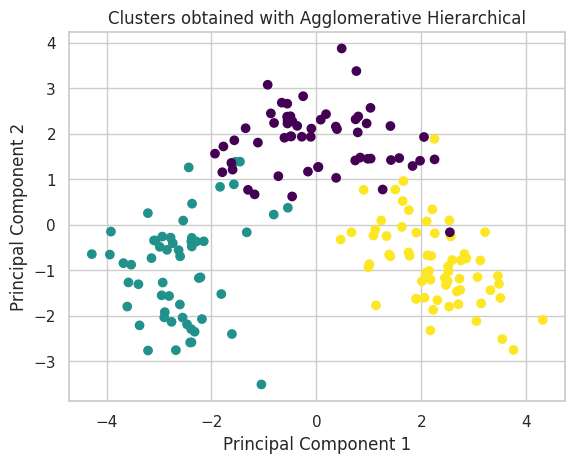

In [25]:
plot_model(X_pca_standard, df['Cluster_Agglomerative'], 'Agglomerative Hierarchical')

#### Silhouette Method

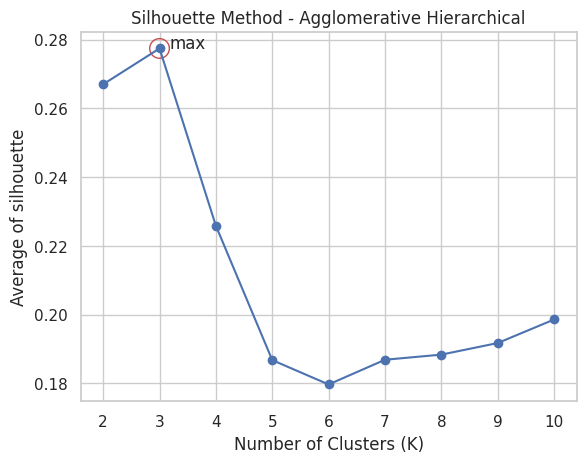

In [26]:
silhouette_avg_values = []

for k in range(2, 11):  # Puedes ajustar el rango según tus necesidades
    model_temp = AgglomerativeClustering(n_clusters=k)
    clusters = model_temp.fit_predict(X_standard)
    silhouette_avg = silhouette_score(X_standard, clusters)
    silhouette_avg_values.append(silhouette_avg)

plot_silhouette_comparation(rng,silhouette_avg_values,'Agglomerative Hierarchical')

### DBSCAN

#### Fit and Prediction

In [27]:
# DBSCAN
dbscan = DBSCAN(eps=2.35, min_samples=12)
df['Cluster_DBSCAN'] = dbscan.fit_predict(X_standard)
print("Number of elements in Clusters")
print(df['Cluster_DBSCAN'].value_counts())

Number of elements in Clusters
-1    75
 0    53
 1    25
 2    25
Name: Cluster_DBSCAN, dtype: int64


In [28]:
# DBSCAN
dbscan_pca = DBSCAN(eps=0.55, min_samples=5)
df['Cluster_DBSCAN_PCA'] = dbscan_pca.fit_predict(X_pca_standard)
print(df['Cluster_DBSCAN_PCA'].value_counts())

 0    71
 1    42
 2    42
-1    23
Name: Cluster_DBSCAN_PCA, dtype: int64


#### Plot model prediction

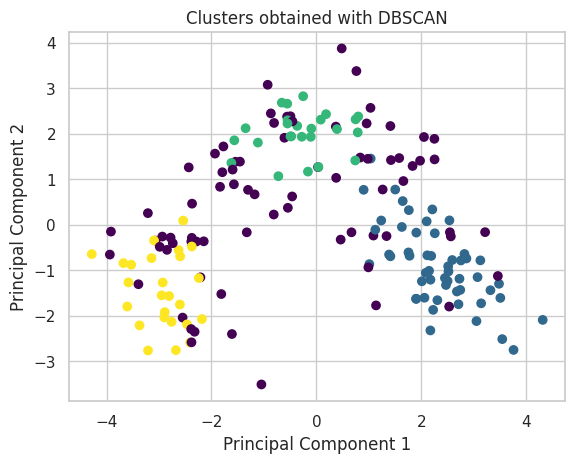

In [29]:
plot_model(X_pca_standard, df['Cluster_DBSCAN'], 'DBSCAN')

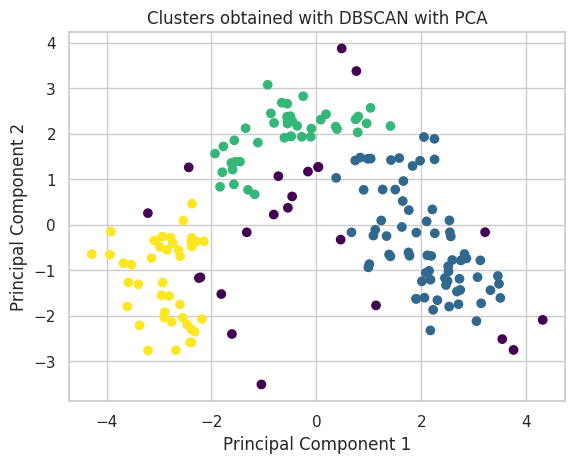

In [30]:
plot_model(X_pca_standard, df['Cluster_DBSCAN_PCA'], 'DBSCAN with PCA')

Con este modelo, se han probado 2 configuraciones. La primera es usando las características con escala estándar dando como resultado más outliers (cantidad en *cluster -1* = 75). Mientras que en el segundo caso, se está usando los valores de la reducción (PCA) de las características con escala estándar donde se obtiene menor cantidad de outliers (cantidad en *cluster -1* = 23). Por lo tanto, al tener menos outliers, la segunda opción es mejor en ser escogida.

In [31]:
del df['Cluster_DBSCAN']

### AffinityPropagation

#### Fit and Prediction

In [32]:
# AffinityPropagation with default configuration

affinity_propagation = AffinityPropagation(random_state=random_state)
clusters = affinity_propagation.fit_predict(X_standard)

print("Number of clusters:", len(affinity_propagation.cluster_centers_indices_))

Number of clusters: 14


In [33]:
# AffinityPropagation with manual configuration

affinity_propagation = AffinityPropagation(damping=0.9,preference=-200.0, random_state=random_state)
df['Cluster_Affinity'] = affinity_propagation.fit_predict(X_standard)

print("Number of clusters:", len(affinity_propagation.cluster_centers_indices_))

Number of clusters: 3


#### Plot model prediction

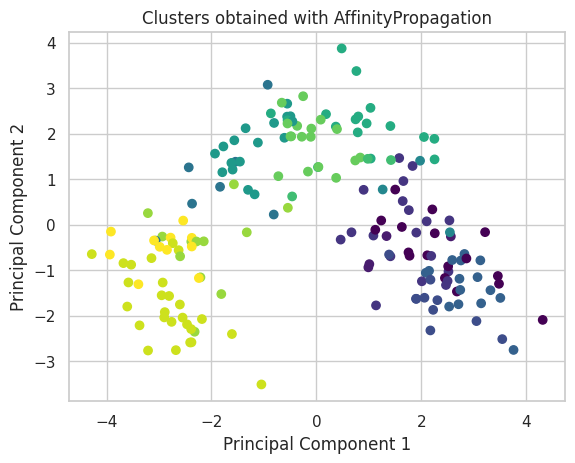

In [34]:
plot_model(X_pca_standard,clusters,'AffinityPropagation')

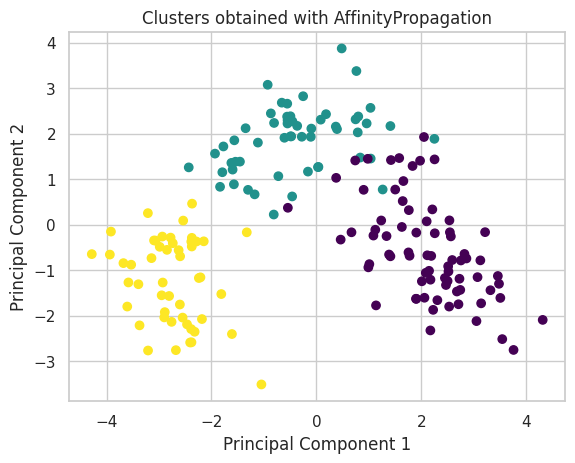

In [35]:
plot_model(X_pca_standard,df['Cluster_Affinity'],'AffinityPropagation')

Para este caso, se ha hecho una configuración manual para que se pueda generar 3 clusters en vez de 14 (como la primera configuracion que es por defecto).

### Spectral Clustering

#### Fit and Prediction

In [36]:
spectral = SpectralClustering(n_clusters=num_clusters,
                              random_state=random_state,
                              affinity='nearest_neighbors')
df['Cluster_Spectral'] = spectral.fit_predict(X_standard)
print("Number of elements in Clusters")
print(df['Cluster_Spectral'].value_counts())

Number of elements in Clusters
0    64
2    63
1    51
Name: Cluster_Spectral, dtype: int64


#### Plot model prediction

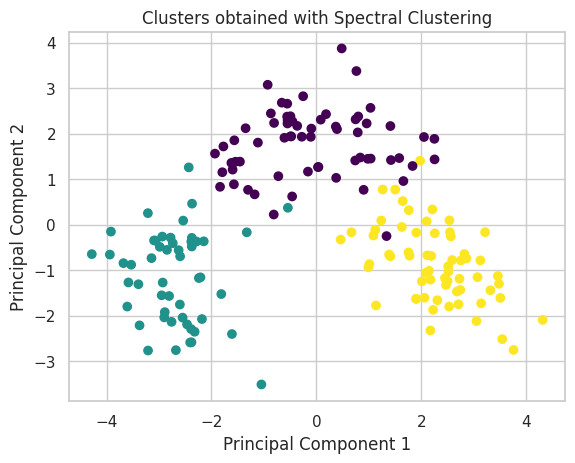

In [37]:
plot_model(X_pca_standard,df['Cluster_Spectral'],'Spectral Clustering')

### Summary

In [38]:
df.head()

Alcohol  Malic_Acid   Ash  Ash_Alcanity  Magnesium  Total_Phenols  \
0    14.23        1.71  2.43          15.6        127           2.80   
1    13.20        1.78  2.14          11.2        100           2.65   
2    13.16        2.36  2.67          18.6        101           2.80   
3    14.37        1.95  2.50          16.8        113           3.85   
4    13.24        2.59  2.87          21.0        118           2.80   

   Flavanoids  Nonflavanoid_Phenols  Proanthocyanins  Color_Intensity   Hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   OD280  Proline  Cluster_KMeans  Cluster_Agglomerative  Cluster_DBSCAN_PCA  \
0   3.92     1065               1                      2                   0   
1   3.40     1050               1                      2                   0   
2   3.17     1185               1                      2                   0   
3   3.45     1480               1                      2                  -1   
4   2.93      735               1                      2                   0   

   Cluster_Affinity  Cluster_Spectral  
0                 0                 2  
1                 0                 2  
2                 0                 2  
3                 0                 2  
4                 0                 2

Se hace una equivalencia entre clusteres generados por cada uno de los modelos. Para ello, se está tomando como modelo pivot 'KMeans', se segmenta por cada cluster de KMeans. Una vez segmentado por cluster, se determina la moda en las columnas tipo 'Cluster_[modelo]', siendo este valor el equivalente al cluster segmentado.

In [39]:
dict_equivalents_model = {col : {df[col][df['Cluster_KMeans']==cluster_i].mode().iloc[0]: cluster_i
                                 for cluster_i in range(3)}  #Iterarion for clusters
                          for col in df.columns[13:]}   #Iteration for columns
dict_equivalents_model

{'Cluster_KMeans': {0: 0, 1: 1, 2: 2},
 'Cluster_Agglomerative': {0: 0, 2: 1, 1: 2},
 'Cluster_DBSCAN_PCA': {1: 0, 0: 1, 2: 2},
 'Cluster_Affinity': {1: 0, 0: 1, 2: 2},
 'Cluster_Spectral': {0: 0, 2: 1, 1: 2}}

Se reemplaza los equivalentes en todas las columnas de Clusters

In [40]:
for col in df.columns[13:]:
  df[col].replace(dict_equivalents_model[col],inplace=True)

In [41]:
df.head()

Alcohol  Malic_Acid   Ash  Ash_Alcanity  Magnesium  Total_Phenols  \
0    14.23        1.71  2.43          15.6        127           2.80   
1    13.20        1.78  2.14          11.2        100           2.65   
2    13.16        2.36  2.67          18.6        101           2.80   
3    14.37        1.95  2.50          16.8        113           3.85   
4    13.24        2.59  2.87          21.0        118           2.80   

   Flavanoids  Nonflavanoid_Phenols  Proanthocyanins  Color_Intensity   Hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   OD280  Proline  Cluster_KMeans  Cluster_Agglomerative  Cluster_DBSCAN_PCA  \
0   3.92     1065               1                      1                   1   
1   3.40     1050               1                      1                   1   
2   3.17     1185               1                      1                   1   
3   3.45     1480               1                      1                  -1   
4   2.93      735               1                      1                   1   

   Cluster_Affinity  Cluster_Spectral  
0                 1                 1  
1                 1                 1  
2                 1                 1  
3                 1                 1  
4                 1                 1

Number of records matching in the same clusters

In [42]:
df[df.iloc[:, 13:].apply(lambda row: row.nunique() == 1, axis=1)].shape

(134, 18)

Number of records that do not match in the same clusters

In [43]:
df[df.iloc[:, 13:].apply(lambda row: row.nunique() != 1, axis=1)].shape

(44, 18)

The voting process is carried out, and it is saved in the 'Cluster_Voting' column.

In [44]:
df['Cluster_Voting'] = df.iloc[:, 13:].mode(axis=1)[0].astype(int)
df.head()

Alcohol  Malic_Acid   Ash  Ash_Alcanity  Magnesium  Total_Phenols  \
0    14.23        1.71  2.43          15.6        127           2.80   
1    13.20        1.78  2.14          11.2        100           2.65   
2    13.16        2.36  2.67          18.6        101           2.80   
3    14.37        1.95  2.50          16.8        113           3.85   
4    13.24        2.59  2.87          21.0        118           2.80   

   Flavanoids  Nonflavanoid_Phenols  Proanthocyanins  Color_Intensity   Hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   OD280  Proline  Cluster_KMeans  Cluster_Agglomerative  Cluster_DBSCAN_PCA  \
0   3.92     1065               1                      1                   1   
1   3.40     1050               1                      1                   1   
2   3.17     1185               1                      1                   1   
3   3.45     1480               1                      1                  -1   
4   2.93      735               1                      1                   1   

   Cluster_Affinity  Cluster_Spectral  Cluster_Voting  
0                 1                 1               1  
1                 1                 1               1  
2                 1                 1               1  
3                 1                 1               1  
4                 1                 1               1

In [45]:
df['Cluster_Voting'].value_counts()

1    66
0    61
2    51
Name: Cluster_Voting, dtype: int64

#### Cluster 0

In [46]:
df_cluster_0 = df[df['Cluster_Voting']==0]
df_cluster_0.describe()

Alcohol  Malic_Acid        Ash  Ash_Alcanity   Magnesium  \
count  61.000000   61.000000  61.000000     61.000000   61.000000   
mean   12.235574    1.929016   2.219344     20.077049   90.540984   
std     0.508490    1.031261   0.285633      2.959414    8.846042   
min    11.030000    0.740000   1.360000     10.600000   70.000000   
25%    11.870000    1.290000   2.000000     18.000000   85.000000   
50%    12.250000    1.610000   2.240000     20.000000   88.000000   
75%    12.430000    2.160000   2.390000     21.600000   97.000000   
max    13.670000    5.800000   2.920000     28.500000  112.000000   

       Total_Phenols  Flavanoids  Nonflavanoid_Phenols  Proanthocyanins  \
count      61.000000   61.000000             61.000000        61.000000   
mean        2.252459    2.049672              0.370000         1.564262   
std         0.529565    0.596789              0.118842         0.566899   
min         1.100000    0.570000              0.130000         0.410000   
25%         1.950000    1.640000              0.280000         1.350000   
50%         2.200000    2.030000              0.370000         1.480000   
75%         2.560000    2.290000              0.430000         1.830000   
max         3.520000    3.750000              0.660000         3.580000   

       Color_Intensity        Hue      OD280     Proline  Cluster_KMeans  \
count        61.000000  61.000000  61.000000   61.000000       61.000000   
mean          2.988033   1.052721   2.798525  498.852459        0.032787   
std           0.862063   0.201899   0.481220  138.296281        0.256074   
min           1.280000   0.690000   1.590000  278.000000        0.000000   
25%           2.450000   0.920000   2.480000  392.000000        0.000000   
50%           2.900000   1.040000   2.840000  480.000000        0.000000   
75%           3.300000   1.190000   3.160000  580.000000        0.000000   
max           5.750000   1.710000   3.640000  886.000000        2.000000   

       Cluster_Agglomerative  Cluster_DBSCAN_PCA  Cluster_Affinity  \
count              61.000000           61.000000         61.000000   
mean                0.180328            0.049180          0.131148   
std                 0.562974            0.560542          0.340363   
min                 0.000000           -1.000000          0.000000   
25%                 0.000000            0.000000          0.000000   
50%                 0.000000            0.000000          0.000000   
75%                 0.000000            0.000000          0.000000   
max                 2.000000            1.000000          1.000000   

       Cluster_Spectral  Cluster_Voting  
count              61.0            61.0  
mean                0.0             0.0  
std                 0.0             0.0  
min                 0.0             0.0  
25%                 0.0             0.0  
50%                 0.0             0.0  
75%                 0.0             0.0  
max                 0.0             0.0

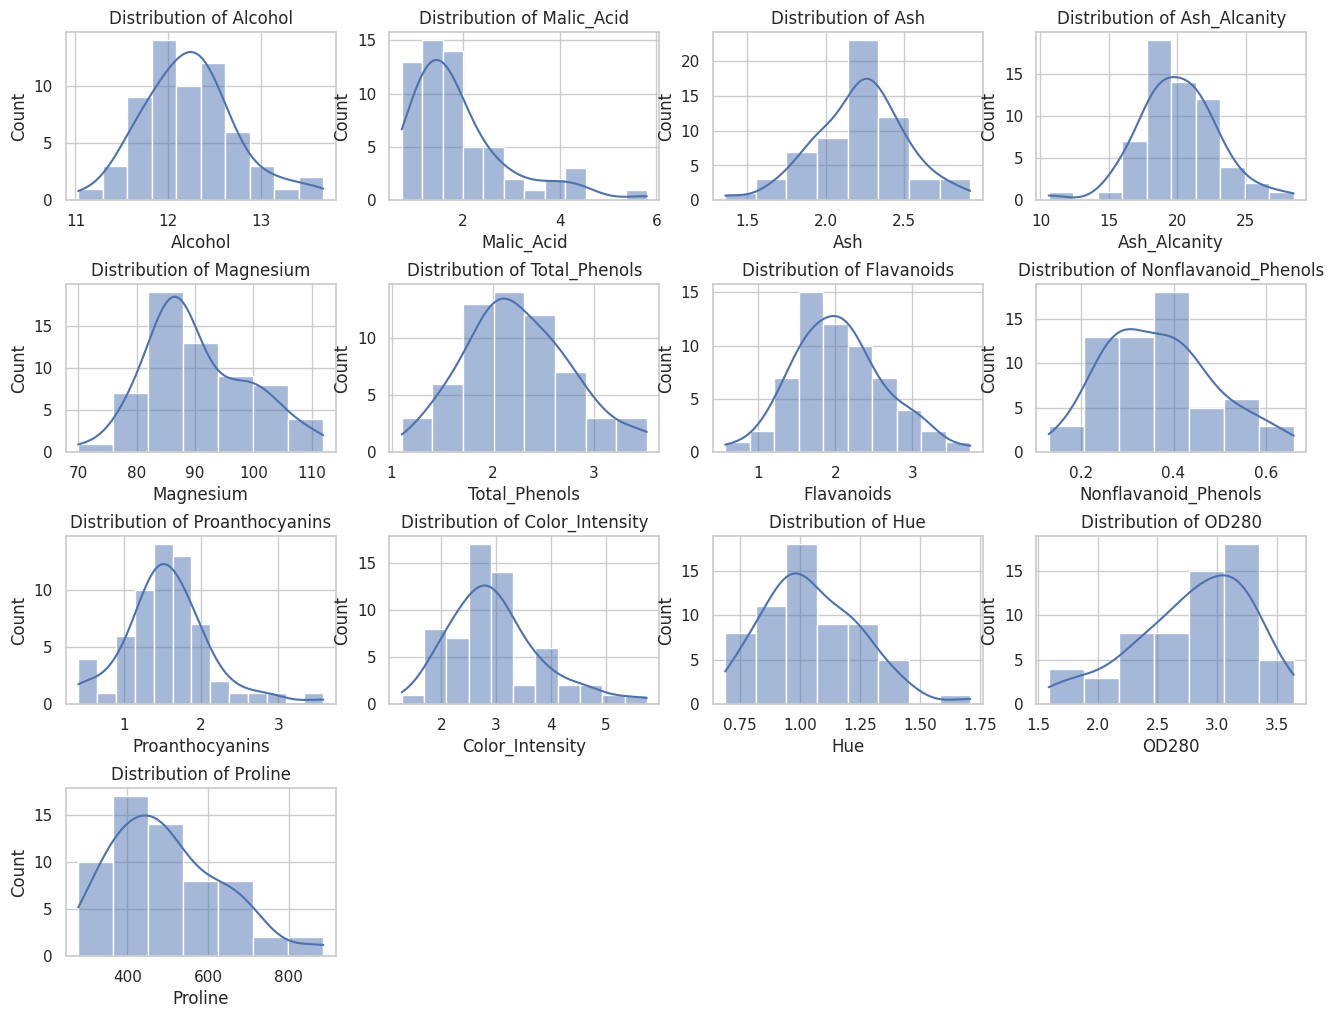

In [47]:
sns.set(style="whitegrid")

plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace=0.5)

for i, column in enumerate(df_cluster_0.columns[:13]):
    plt.subplot(4, 4, i + 1)
    sns.histplot(df_cluster_0[column], kde=True)
    plt.title(f'Distribution of {column}')

plt.show()

#### Cluster 1

In [48]:
df_cluster_1 = df[df['Cluster_Voting']==1]
df_cluster_1.describe()

Alcohol  Malic_Acid        Ash  Ash_Alcanity   Magnesium  \
count  66.000000   66.000000  66.000000     66.000000   66.000000   
mean   13.617121    1.951061   2.452121     17.536364  108.560606   
std     0.614433    0.681950   0.262781      3.356951   14.544498   
min    11.560000    0.990000   1.750000     11.200000   86.000000   
25%    13.250000    1.642500   2.282500     16.000000   98.000000   
50%    13.725000    1.740000   2.445000     17.000000  105.500000   
75%    14.060000    1.915000   2.617500     18.875000  116.000000   
max    14.830000    4.040000   3.230000     30.000000  162.000000   

       Total_Phenols  Flavanoids  Nonflavanoid_Phenols  Proanthocyanins  \
count      66.000000   66.000000             66.000000        66.000000   
mean        2.813182    2.952121              0.290606         1.945152   
std         0.374401    0.530972              0.074748         0.443025   
min         1.850000    1.280000              0.140000         1.250000   
25%         2.600000    2.657500              0.242500         1.660000   
50%         2.800000    2.930000              0.290000         1.935000   
75%         3.000000    3.237500              0.320000         2.130000   
max         3.880000    5.080000              0.500000         3.280000   

       Color_Intensity        Hue      OD280      Proline  Cluster_KMeans  \
count        66.000000  66.000000  66.000000    66.000000       66.000000   
mean          5.338636   1.075000   3.135909  1072.272727        0.954545   
std           1.343496   0.125088   0.382397   253.455962        0.209895   
min           2.600000   0.820000   2.300000   410.000000        0.000000   
25%           4.365000   1.010000   2.855000   916.250000        1.000000   
50%           5.245000   1.070000   3.130000  1062.500000        1.000000   
75%           6.182500   1.157500   3.430000  1268.750000        1.000000   
max           8.900000   1.360000   4.000000  1680.000000        1.000000   

       Cluster_Agglomerative  Cluster_DBSCAN_PCA  Cluster_Affinity  \
count              66.000000           66.000000         66.000000   
mean                0.954545            0.818182          0.984848   
std                 0.209895            0.579365          0.123091   
min                 0.000000           -1.000000          0.000000   
25%                 1.000000            1.000000          1.000000   
50%                 1.000000            1.000000          1.000000   
75%                 1.000000            1.000000          1.000000   
max                 1.000000            1.000000          1.000000   

       Cluster_Spectral  Cluster_Voting  
count         66.000000            66.0  
mean           0.954545             1.0  
std            0.209895             0.0  
min            0.000000             1.0  
25%            1.000000             1.0  
50%            1.000000             1.0  
75%            1.000000             1.0  
max            1.000000             1.0

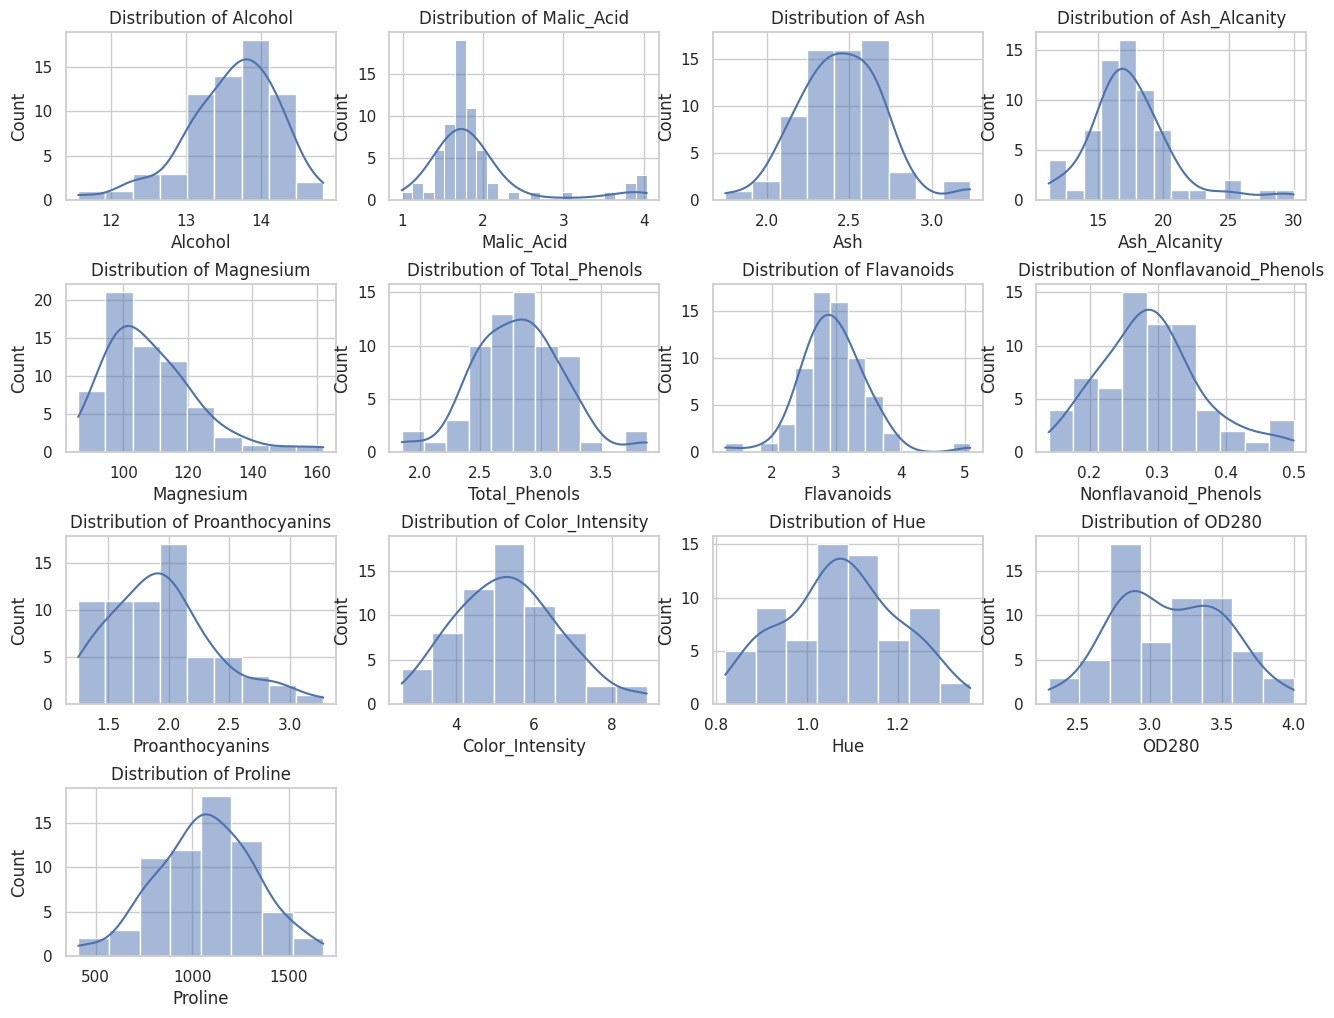

In [49]:
sns.set(style="whitegrid")

plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace=0.5)

for i, column in enumerate(df_cluster_1.columns[:13]):
    plt.subplot(4, 4, i + 1)
    sns.histplot(df_cluster_1[column], kde=True)
    plt.title(f'Distribution of {column}')

plt.show()

#### Cluster 2

In [50]:
df_cluster_2 = df[df['Cluster_Voting']==2]
df_cluster_2.describe()

Alcohol  Malic_Acid        Ash  Ash_Alcanity   Magnesium  \
count  51.000000   51.000000  51.000000     51.000000   51.000000   
mean   13.117843    3.322157   2.431765     21.333333   99.333333   
std     0.549768    1.071250   0.195762      2.323073   12.128754   
min    11.810000    1.240000   1.980000     16.000000   80.000000   
25%    12.780000    2.585000   2.300000     20.000000   89.000000   
50%    13.110000    3.270000   2.380000     21.000000   97.000000   
75%    13.495000    3.905000   2.605000     22.750000  106.000000   
max    14.340000    5.650000   2.860000     27.000000  134.000000   

       Total_Phenols  Flavanoids  Nonflavanoid_Phenols  Proanthocyanins  \
count      51.000000   51.000000             51.000000        51.000000   
mean        1.675686    0.810588              0.444314         1.164314   
std         0.346354    0.313760              0.130004         0.408349   
min         0.980000    0.340000              0.140000         0.550000   
25%         1.445000    0.580000              0.395000         0.850000   
50%         1.630000    0.700000              0.470000         1.110000   
75%         1.800000    0.975000              0.530000         1.375000   
max         2.800000    1.590000              0.630000         2.700000   

       Color_Intensity        Hue      OD280     Proline  Cluster_KMeans  \
count        51.000000  51.000000  51.000000   51.000000       51.000000   
mean          7.170980   0.691373   1.709804  622.490196        1.960784   
std           2.429391   0.119013   0.285457  118.284635        0.280056   
min           2.500000   0.480000   1.270000  372.000000        0.000000   
25%           5.140000   0.590000   1.530000  525.000000        2.000000   
50%           7.300000   0.670000   1.680000  625.000000        2.000000   
75%           9.105000   0.765000   1.845000  690.000000        2.000000   
max          13.000000   0.960000   2.470000  880.000000        2.000000   

       Cluster_Agglomerative  Cluster_DBSCAN_PCA  Cluster_Affinity  \
count                   51.0           51.000000         51.000000   
mean                     2.0            1.470588          1.941176   
std                      0.0            1.155040          0.310597   
min                      2.0           -1.000000          0.000000   
25%                      2.0            2.000000          2.000000   
50%                      2.0            2.000000          2.000000   
75%                      2.0            2.000000          2.000000   
max                      2.0            2.000000          2.000000   

       Cluster_Spectral  Cluster_Voting  
count              51.0            51.0  
mean                2.0             2.0  
std                 0.0             0.0  
min                 2.0             2.0  
25%                 2.0             2.0  
50%                 2.0             2.0  
75%                 2.0             2.0  
max                 2.0             2.0

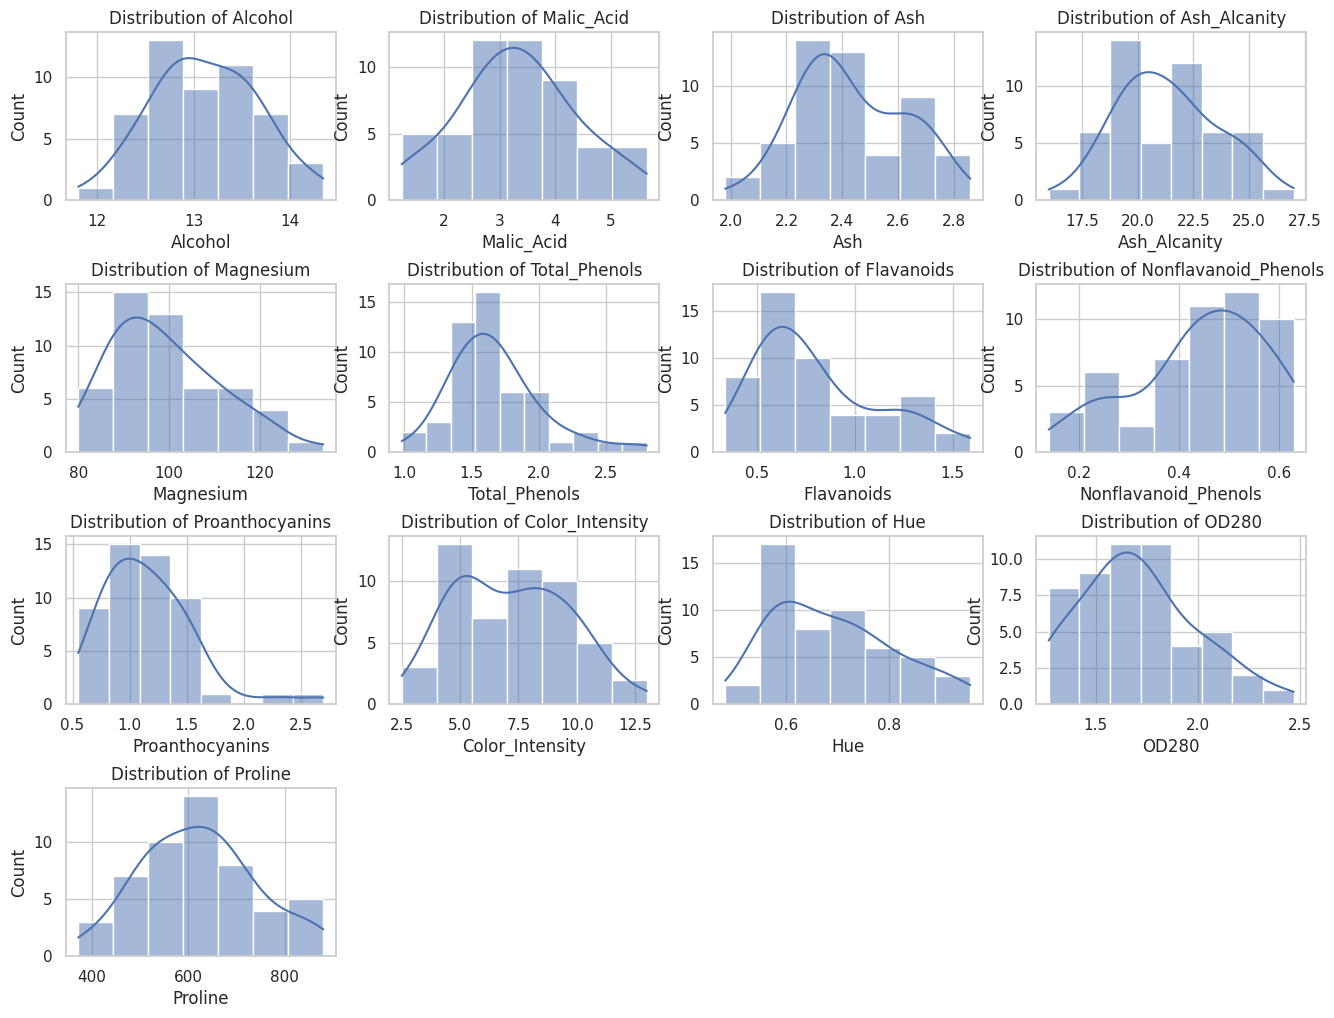

In [51]:
sns.set(style="whitegrid")

plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace=0.5)

for i, column in enumerate(df_cluster_2.columns[:13]):
    plt.subplot(4, 4, i + 1)
    sns.histplot(df_cluster_2[column], kde=True)
    plt.title(f'Distribution of {column}')

plt.show()

#### Violin Plot

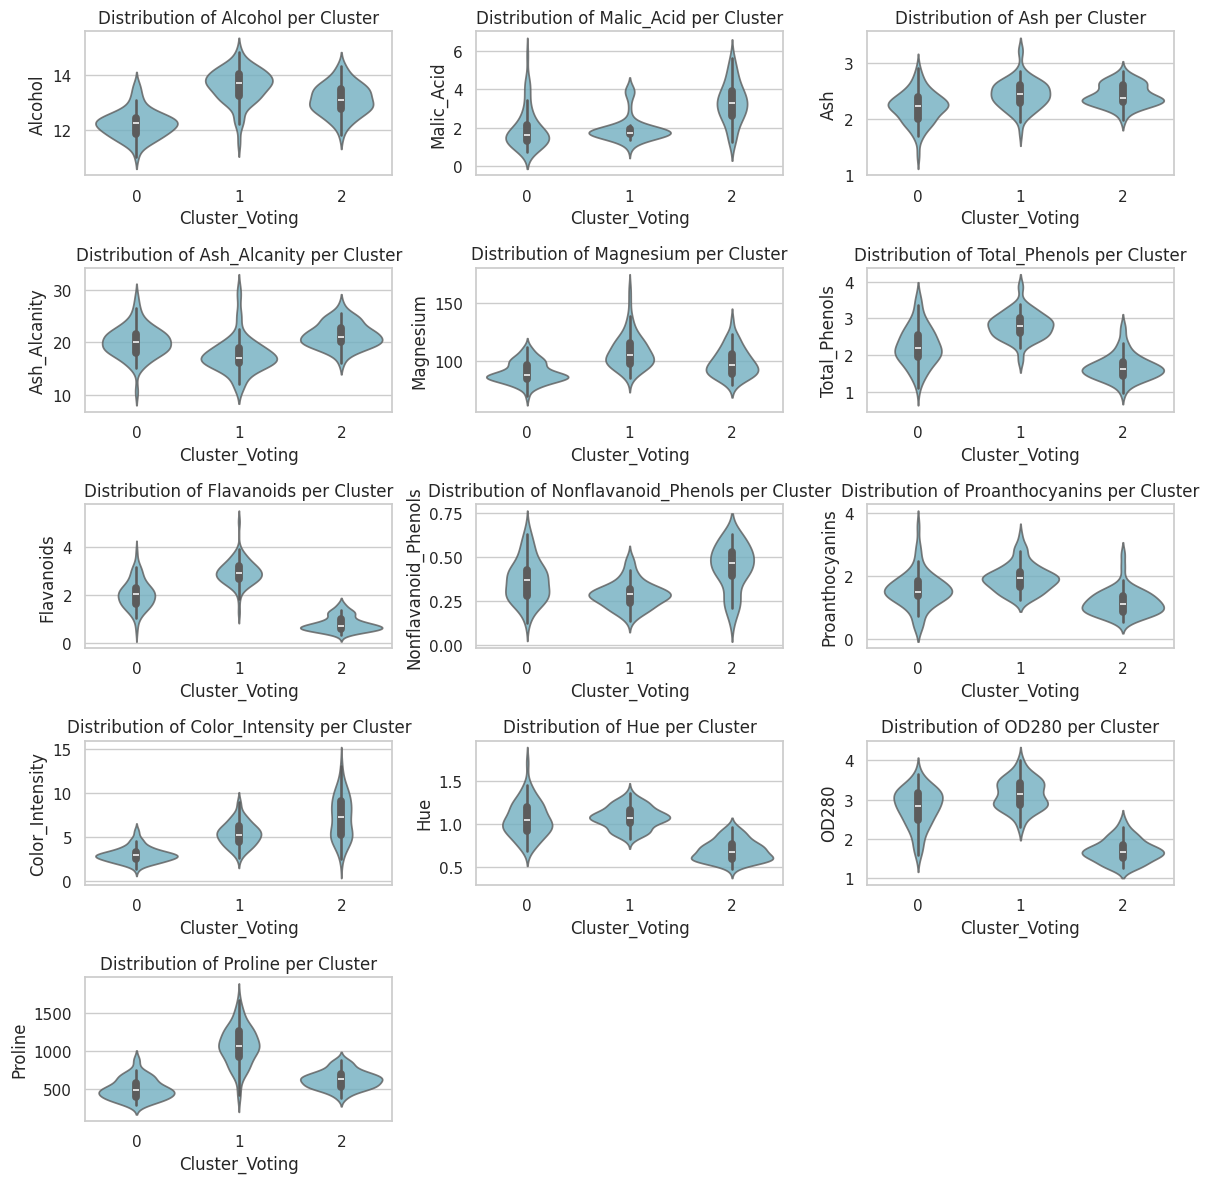

In [52]:
sns.set(style="whitegrid")

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
num_models = len(df.columns[13:])

plt.figure(figsize=(12, 12))
for i, column in enumerate(df.columns[:13]):
    plt.subplot(5, 3, i + 1)
    sns.violinplot(x='Cluster_Voting', y=column, data=df,color='c',alpha=0.8)
    # for i,col in enumerate(df.columns[13:]):
    #   sns.violinplot(x=col, y=column, data=df, alpha=1/num_models, color=colors[i])
    plt.title(f'Distribution of {column} per Cluster')

plt.tight_layout()
plt.show()

#### Analysis of clusters

**Cluster 0**:
* **Menor porcentaje de alcohol**: Un vino con un menor porcentaje de alcohol generalmente será más ligero en cuerpo y puede tener menos calor en el paladar.

* **Poco magnesio**: El magnesio en el vino proviene principalmente del suelo en el que se cultivan las uvas. Un bajo contenido de magnesio puede indicar un suelo con bajo contenido de este mineral.

* **Poco ácido málico**: Como mencioné antes, un vino con bajo contenido de ácido málico puede tener un sabor más suave y menos ácido.

* **Poco ‘ash’ pero mayor ‘ash alkalinity’**: El ‘ash’ en el vino se refiere a los minerales inorgánicos que quedan después de la evaporación y la incineración. Una mayor alcalinidad de la ceniza puede indicar un pH más alto (menos acidez) en el vino.

* **Color de intensidad bajo**: Esto podría indicar un vino más ligero, posiblemente más viejo, ya que los vinos tienden a perder color con la edad.

* **Baja prolina**: La prolina es un aminoácido que se encuentra en las uvas. Los niveles de prolina pueden ser influenciados por una variedad de factores, incluyendo la variedad de uva, el clima y las prácticas de vinificación. Un bajo nivel de prolina no necesariamente indica una calidad inferior del vino.

**Conclusión**: En este cluster, que es un viñedo, tiene los vinos más suaves y ligeros en cuerpo. Es menos ácido. Puede que sea un vino viejo, pero lo más probable es que se trate de vinos blancos o rosé por el bajo nivel de intensidad de color. También, por la cantidad de prolina baja, se podría decir que se trata de vinos blancos


**Cluster 1**:
- **Mayor porcentaje de alcohol**: Un vino con un mayor porcentaje de alcohol generalmente será más completo en cuerpo y puede tener más calor en el paladar.
- **Poco ácido málico**: Como mencioné antes, un vino con bajo contenido de ácido málico puede tener un sabor más suave y menos ácido.
- **Mayor 'ash' pero menor 'ash alkalinity'**: El 'ash' en el vino se refiere a los minerales inorgánicos que quedan después de la evaporación y la incineración. Una menor alcalinidad de la ceniza puede indicar un pH más bajo (más acidez) en el vino.
- **Mayor cantidad de fenoles y flavanoides**: Los fenoles, incluyendo los flavanoides, son compuestos que contribuyen al color y al sabor del vino. Un alto contenido de estos compuestos puede indicar un vino con un sabor más complejo y posiblemente un color más oscuro.
- **Menor cantidad de fenoles no flavanoides**: Los fenoles no flavanoides también contribuyen al sabor y al color del vino. Un bajo contenido de estos compuestos puede indicar un vino con un sabor menos astringente.
- **Mayor cantidad de proanthocyanins**: Las proantocianidinas son un tipo de tanino que contribuye a la astringencia y al color del vino. Un alto contenido de proantocianidinas puede indicar un vino con un sabor más astringente y posiblemente un color más oscuro.
- **Mayor prolina**: La prolina es un aminoácido que se encuentra en las uvas. Un alto nivel de prolina puede indicar una variedad de uva con un alto contenido de este aminoácido, o puede ser el resultado de ciertas prácticas de vinificación.

**Conclusión**: En este cluster, los vinos tienen un cuerpo más robusto, más cálido, más complejo. Tiene un color más oscuro. Por la mayor concentración de prolina, se podria decir que serían vinos tinto.

**Cluster 2**
- **Valor promedio de alcohol**: Un vino con un valor promedio de alcohol generalmente será medio en cuerpo y puede tener un calor moderado en el paladar.
- **Mayor cantidad de ácido málico**: Un vino con mayor contenido de ácido málico puede tener un sabor más ácido y fresco.
- **Mayor alcalinidad de ash**: La alcalinidad de la ceniza puede indicar un pH más alto (menos acidez) en el vino.
- **Bajo nivel de fenoles totales y flavanoides**: Los fenoles, incluyendo los flavanoides, son compuestos que contribuyen al color y al sabor del vino. Un bajo contenido de estos compuestos puede indicar un vino con un sabor menos complejo y posiblemente un color más claro.
- **Mayor cantidad de nonflavanoid phenols**: Los fenoles no flavanoides también contribuyen al sabor y al color del vino. Un alto contenido de estos compuestos puede indicar un vino con un sabor más astringente.
- **Baja cantidad de proanthocyanins**: Las proantocianidinas son un tipo de tanino que contribuye a la astringencia y al color del vino. Un bajo contenido de proantocianidinas puede indicar un vino con un sabor menos astringente y posiblemente un color más claro.

**Conclusión**: Para este cluster, se concluye que tiene un cuerpo moderado, con un sabor ácido y fresco. Se puede decir que tiene un color claro por los bajos niveles de fenoles. Como tiene prolina cercano al primer cluster, se puede estimar que se trata de vinos rosados.

## Storytelling

### **Desafío enológico: El Viaje de Bills en Busca del Vino Perfecto**

**Bills es un químico reconocido que ha investigado profundamente todo relacionado a los vinos**. Él realiza expediciones en diferentes partes del mundo para encontrar el mejor vino. No obstante, el cree que cada vino es único, y no todos los paladares tienen los mismos gustos, por lo que viaja específicamente para recolectar muestras químicas a fin de recolectar los diferentes perfiles de los vinos y recomendarlos a sus seguidores, pues también **es influencer en la plataforma de TikTok**.

En uno de sus viajes a **Italia**, visitó **3 viñedos** poco conocidos pero con una alta aprobación local. Dado que su GPS no pudo determinar exactamente los lugares pues solo iba guiado por el guía. Finalmente, llegó a cada uno de los viñedos y se maravilló por el gusto único y exquisito que tenían estos vinos. **Cada viñedo se especializaba en un tipo de vino: blanco, tinto o rosado**. Ansiosamente, y con un mucho entusiasmo, llegó a realizar las pruebas químicas de unos 178 vinos en total.

De camino casa, y con todas las pruebas realizadas satisfactoriamente, Bills se percata de un gran problema que no había contemplado: **olvido colocar las etiquetas** para poder identificar la procedencia de los vinos. Bills estaba profundamente preocupado y triste, ¿cómo podía haber olvidado de colocar las etiquetas?¿Fue porque estaba emocionado? ¿la máquina falló y eliminó la columna de las etiquetas? ¿su hermano Champa tendrá algo que ver?

Ya no importaba, solo tenía **13 características de cada muestra** las cuales estaban completas y sin valores nulos, pero sin etiquetas. Tenía que buscar una solución, pues ya se había comprometido con sus seguidores de TikTok. Para ello ideó un plan de estrategia, **usar algoritmos de machine learning para poder clasificar o agrupar**, según las características, y poder informar del perfil de cada tipo de vino.

A continuación se muestran los resultados que se encontraron:


#### **Cluster 0: Blancos Brillantes - "El Resplandor del Sol"**

En el Cluster de Blancos Brillantes, descubrimos vinos que capturan la esencia radiante de los días soleados. Estos vinos blancos, procedentes de la región cálida de Toscana, deslumbran con su frescura y su cuerpo ligero. Como los rayos de sol que acarician las uvas, estos vinos son una explosión de cítricos y notas florales. Su perfil fresco y ligero lo hace ideal para acompañar comidas más ligeras, como ensaladas de pollo o pavo, y una excelente opción para acompañar aperitivos antes de la comida.

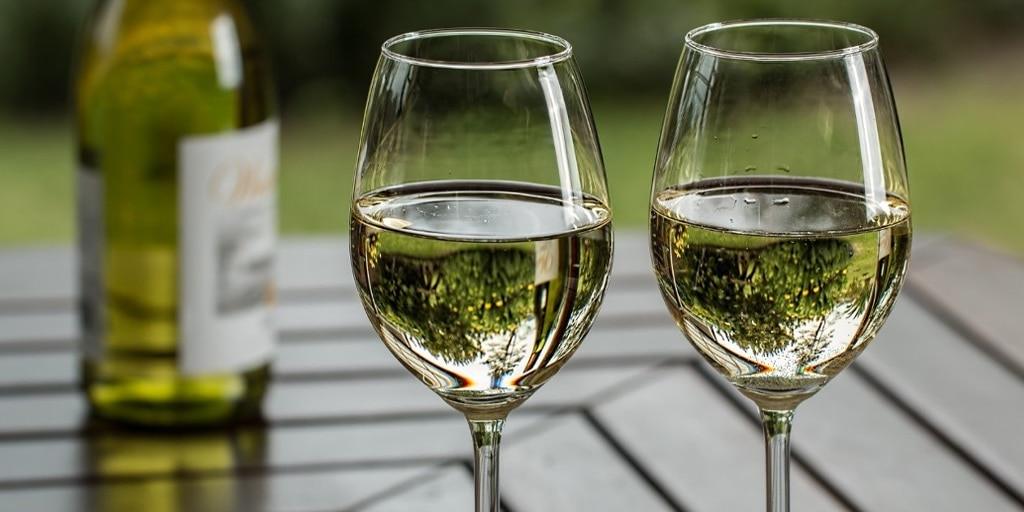

#### **Cluster 1: Tintos Robustos - "El Corazón de la Tierra"**



Adentrándonos en el Cluster de Tintos Robustos, exploramos la profundidad y la riqueza de vinos que se arraigan en la tierra. Provenientes de las colinas de la región fresca de Piemonte, estos tintos revelan capas de frutas maduras, taninos sedosos y toques de especias. Cada sorbo es como un viaje al corazón mismo de la viña. Al tener cuerpo robusto, es ideal al complementar con carnes rojas, como filetes y asados. Una muy buena opción para degustar en una reunión familiar u otro evento social.


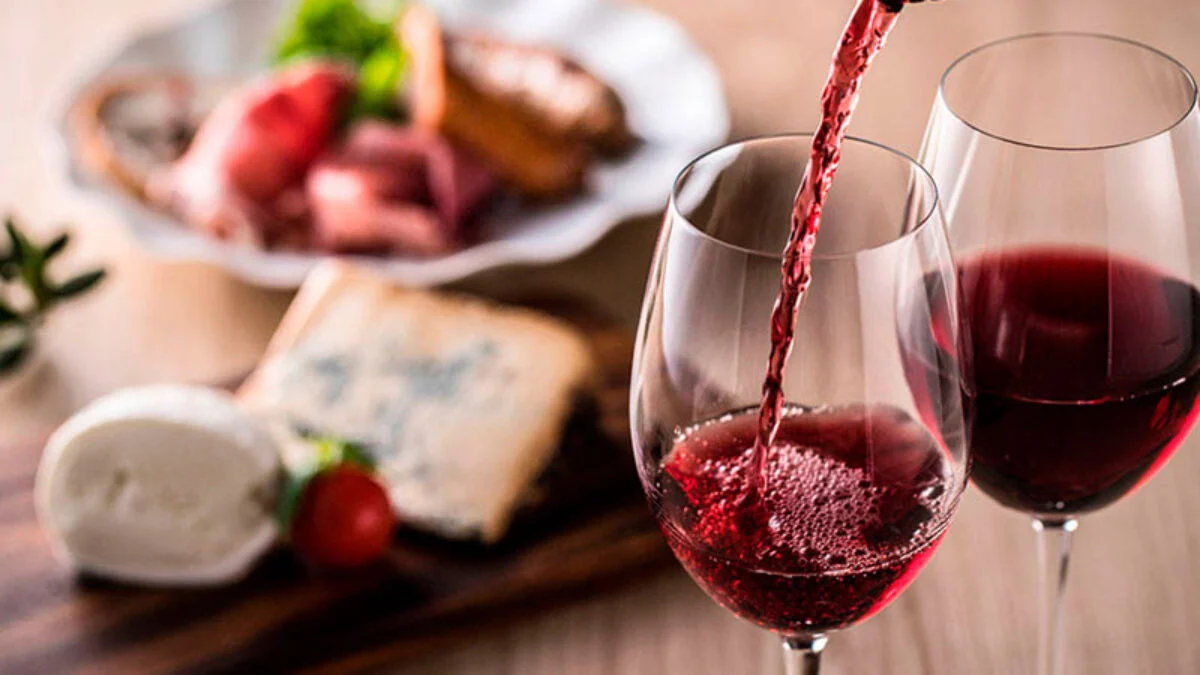

#### **Cluster 2: Rosados Vibrantes - "La Danza de la Alegría"**

En el animado Cluster de Rosados Vibrantes, nos sumergimos en la energía fresca y juvenil de estos vinos rosados. Nacidos en las regiones costeras de Italia, en la encantadora Veneto, estos vinos son como una danza alegre de sabores de frutas rojas y flores primaverales. Son la expresión vívida de la alegría en cada copa. Por su aroma, sabores frutales y la acidez moderada, es ideal para complementarlo con aperitivos, postres o comidas ligeras.


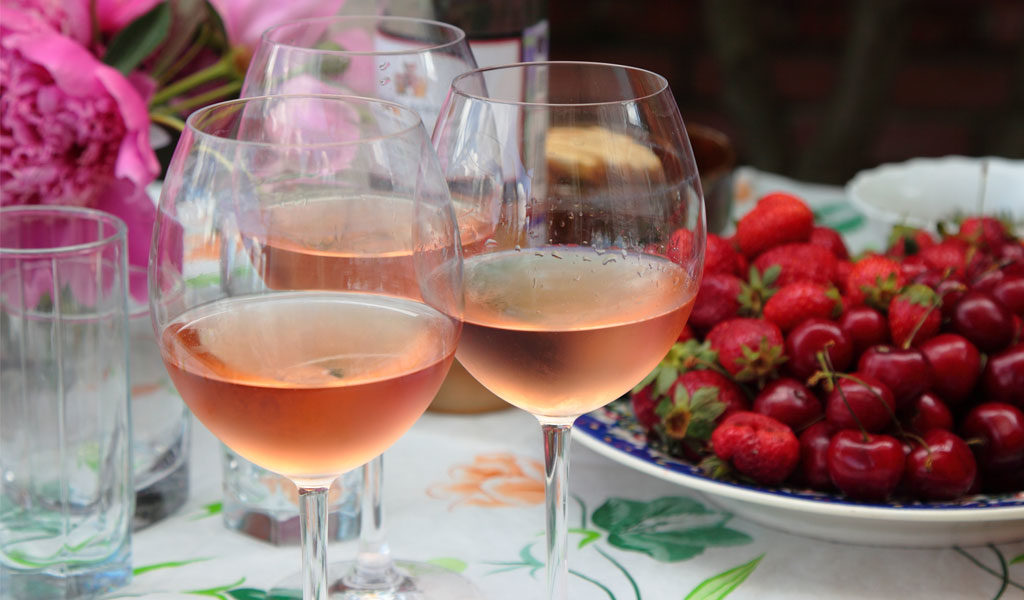

#### **Conclusión**

Bills quedó completamente fascinado con las descripciones de los perfiles pues es idénticamente lo que sintió y vio cuando realizaba las pruebas: un resplandor caluroso de un sol saliente, el corazón de una tierra fértil, y una danza de sabores frutales alegres.

Al reflexionar sobre la pérdida de datos, se dio cuenta de que quizás no era una experiencia tan negativa después de todo; más bien, la consideró una valiosa lección. Debío de haber estado más concentrado al hacer sus pruebas, también tener mayor atención a los lugares donde estaba, capturar momentos, preguntar por el nombre de las ciudades donde iba, sentir el clima, la tierra.

Publicó los nuevos perfiles encontrados en Italia en su TikTok, lo que provocó que muchas más personas lo siguieran, y a su vez, los viñedos que no eran tan conocidos inicialmente, tuvieran una mayor atención.

Más tarde, Bills, con más serenidad, se dirigió a la cena familiar a la que le había invitado su hermano Champa, donde todos sus familiares estarían reunidos. Durante mucho tiempo, Bills había guardado un vino muy especial, esperando la ocasión perfecta para degustarlo. En ese momento de reflexión, consideró que quizás la reunión familiar era la ocasión ideal para compartir y disfrutar de ese tesoro enológico que había guardado con tanto cariño. Con una sonrisa de anticipación, se unió a la mesa, listo para brindar y crear memorias inolvidables con sus seres queridos.